# **Bibliotecas**

In [1]:
%%capture

!pip install shap
!pip install optuna

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

# **Funções**

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [3]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [4]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1gCvb72254hSgR3uRDNnkuvypdKMDXE-E --quiet # Colorretal
!gdown 1-5TMUdCHgLEBig1F5a4rRuTT5MdT4Lrw --quiet # Pulmão
!gdown 1-AY70uv61sBGJbUFCiF8Igyes3eP6ymm --quiet # Mama
!gdown 1-ApWhBLZG4NdOtLiwlaYflR2EzTB5vV8 --quiet # Colo de Útero
!gdown 1-HKn3Rk1i9hRAK06khtSF9lf9bInZ3HS --quiet # Próstata
!gdown 1-PJi2-Tu6-AD9PVmVb5Pbx3IzVy8vnr3 --quiet # Pele

In [5]:
# Leitura dos dados de colorretal
df_colorretal = pd.read_csv('colorretal.csv')
print(df_colorretal.shape)
df_colorretal.head(3)

(60887, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


In [6]:
# Valores faltantes
df_colorretal.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [7]:
df_colorretal_ano1 = df_colorretal[~((df_colorretal.obito_geral == 0) & (df_colorretal.sobrevida_ano1 == 0))].reset_index(drop=True)
df_colorretal_ano1.head(3)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


In [8]:
# Correlação com a saída
corr_matrix = df_colorretal_ano1.corr()
abs(corr_matrix['sobrevida_ano1']).sort_values(ascending = False).head(20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


sobrevida_ano1        1.000000
sobrevida_ano3        0.539301
obito_geral           0.443295
sobrevida_ano5        0.370485
TRATCONS              0.283498
DIAGTRAT              0.281606
NENHUM                0.276085
CIRURGIA              0.238830
QUIMIO                0.192812
presenca_rec          0.169988
IDADE                 0.115831
RADIO                 0.091586
DIAGPREV              0.090153
CATEATEND             0.083414
ESCOLARI_preench      0.080428
OUTROS                0.040122
ANODIAG               0.039368
HORMONIO              0.028891
SEXO                  0.022836
IBGE_idem_IBGEATEN    0.021372
Name: sobrevida_ano1, dtype: float64

In [9]:
# Quantidade de pacientes em cada classe da saída
df_colorretal_ano1.sobrevida_ano1.value_counts()

1    45697
0    13079
Name: sobrevida_ano1, dtype: int64

## **Pré-processamento**

In [10]:
df_colorretal_ano1.columns

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'TOPO', 'TOPOGRUP',
       'EC', 'TRATHOSP', 'NENHUM', 'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO',
       'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG',
       'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench',
       'IBGE_idem_IBGEATEN', 'presenca_rec', 'obito_geral', 'sobrevida_ano1',
       'sobrevida_ano3', 'sobrevida_ano5'],
      dtype='object')

In [11]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano3', 'sobrevida_ano5']

lb = 'sobrevida_ano1'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_colorretal_ano1,
                                                                       list_drop, lb,
                                                                    #    ohe_encoder=['TRATHOSP'],
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (44082, 25), X_test = (14694, 25)
y_train = (44082,), y_test = (14694,)


In [12]:
y_train.value_counts(normalize=True)

1    0.777483
0    0.222517
Name: sobrevida_ano1, dtype: float64

In [13]:
y_test.value_counts(normalize=True)

1    0.77746
0    0.22254
Name: sobrevida_ano1, dtype: float64

# **Treinamento e validação dos modelos de machine learning**

## **Random Forest**


### **Modelo Base**

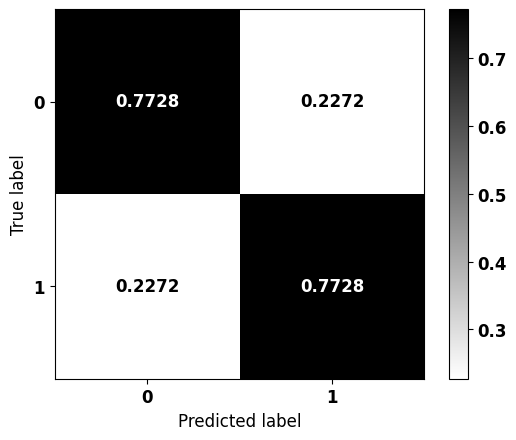


              precision    recall  f1-score   support

           0     0.4933    0.7728    0.6022      3270
           1     0.9224    0.7728    0.8410     11424

    accuracy                         0.7728     14694
   macro avg     0.7078    0.7728    0.7216     14694
weighted avg     0.8269    0.7728    0.7878     14694



In [14]:
# Criação e treinamento do modelo Random Forest
rf = RandomForestClassifier(random_state=seed,
                            class_weight={0:4.6999, 1:1},
                            max_depth=10,
                            criterion='entropy')

rf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

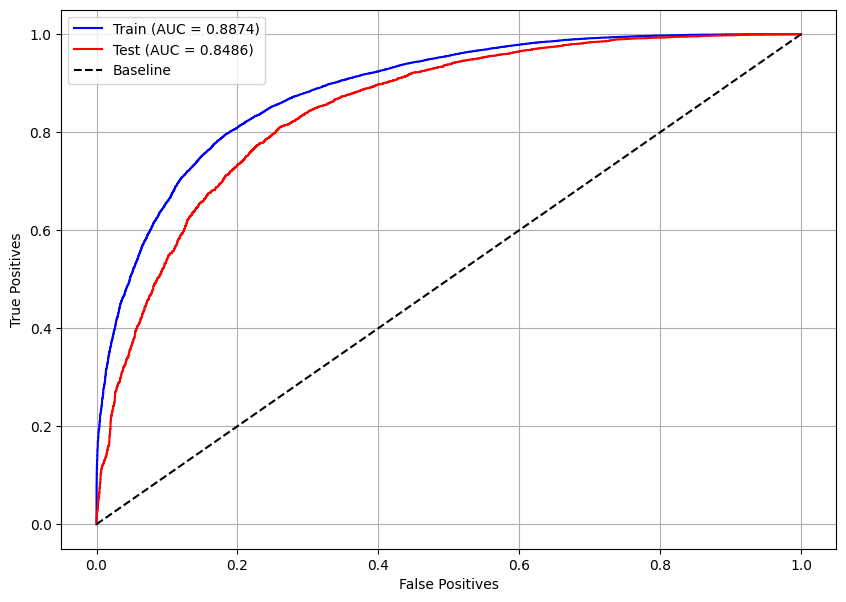

In [ ]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


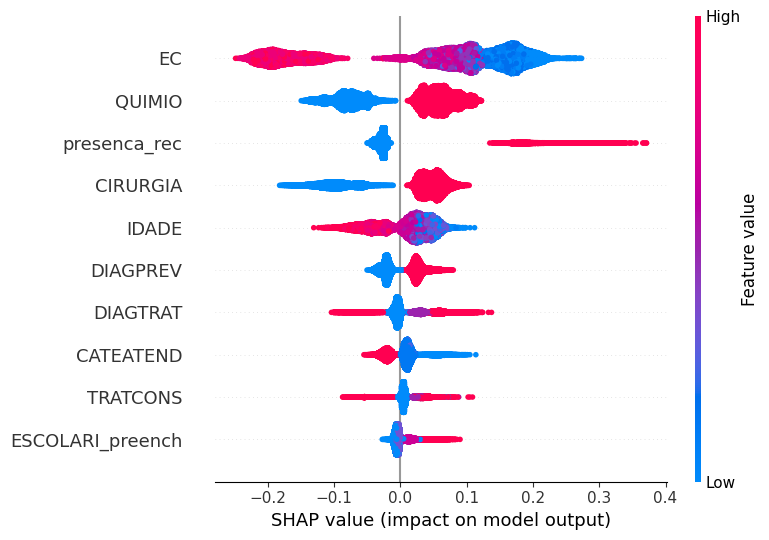

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(rf, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    # optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                #  criterion=optimizer,
                                 random_state=seed,
                                 n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=82, state=TrialState.COMPLETE, values=[0.8412731146364123], datetime_start=datetime.datetime(2023, 10, 10, 12, 54, 36, 355719), datetime_complete=datetime.datetime(2023, 10, 10, 12, 55, 56, 630689), params={'n_estimators': 148, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8999999999999999, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=82, value=None)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 148,
 'max_depth': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_samples': 0.8999999999999999,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(4.6, 4.65, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

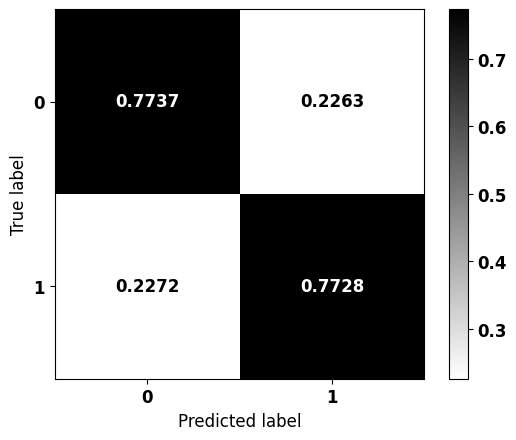


              precision    recall  f1-score   support

           0     0.4936    0.7737    0.6027      3270
           1     0.9227    0.7728    0.8411     11424

    accuracy                         0.7730     14694
   macro avg     0.7081    0.7732    0.7219     14694
weighted avg     0.8272    0.7730    0.7880     14694



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.63, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

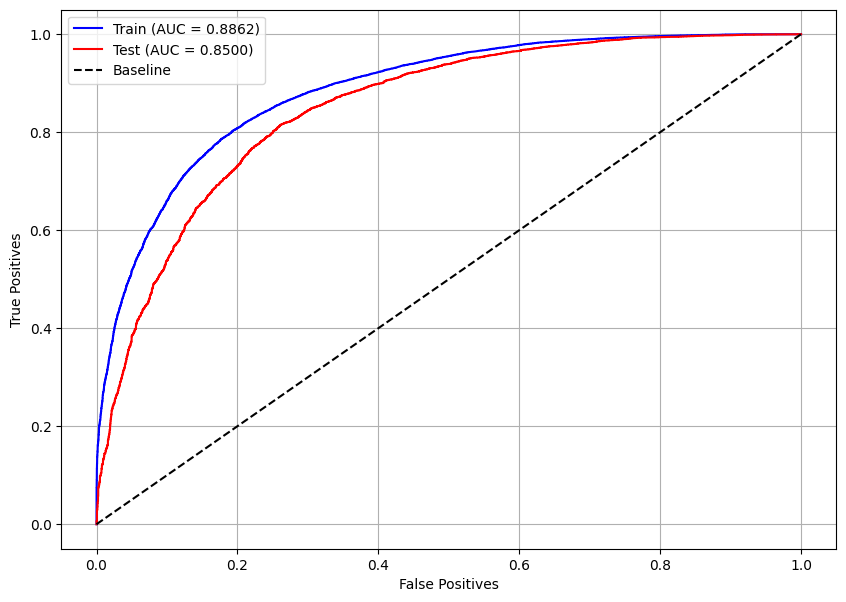

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 104,
 'max_depth': 10,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_samples': 0.8999999999999999,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(4.6, 4.65, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

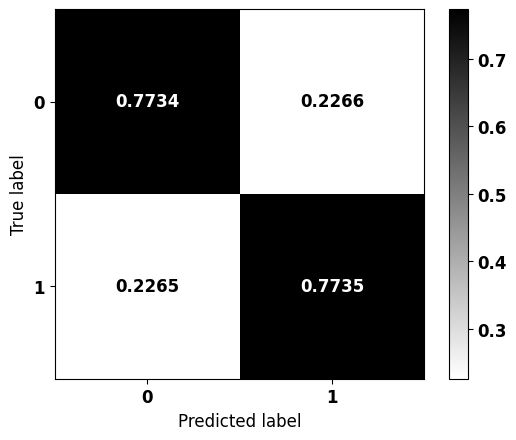


              precision    recall  f1-score   support

           0     0.4943    0.7734    0.6031      3270
           1     0.9226    0.7735    0.8415     11424

    accuracy                         0.7735     14694
   macro avg     0.7085    0.7735    0.7223     14694
weighted avg     0.8273    0.7735    0.7885     14694



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.605, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

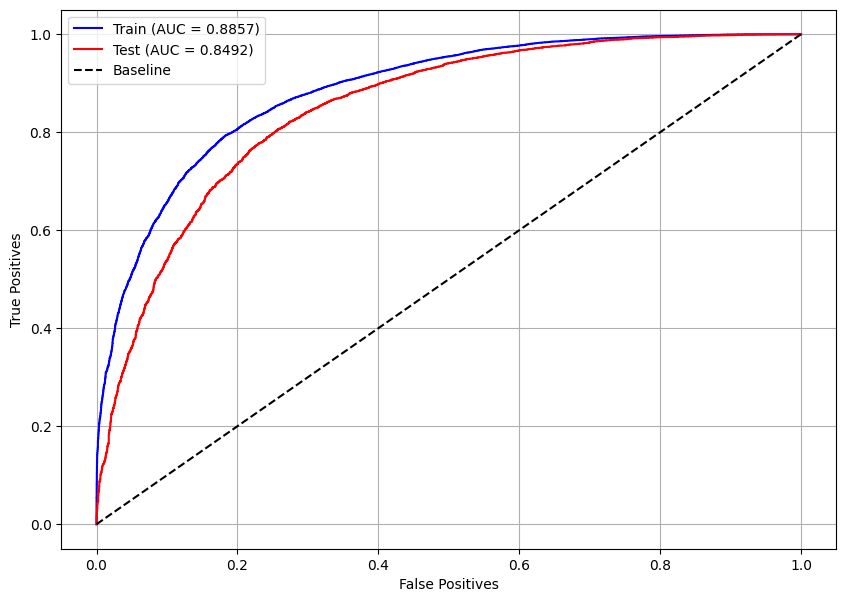

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 118,
 'max_depth': 10,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_samples': 0.7999999999999999}

In [ ]:
pesos = np.round(np.arange(4.63, 4.68, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

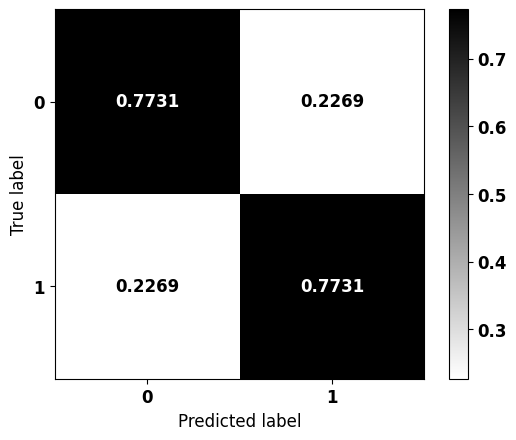


              precision    recall  f1-score   support

           0     0.4938    0.7731    0.6026      3270
           1     0.9225    0.7731    0.8412     11424

    accuracy                         0.7731     14694
   macro avg     0.7081    0.7731    0.7219     14694
weighted avg     0.8271    0.7731    0.7881     14694



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.662, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

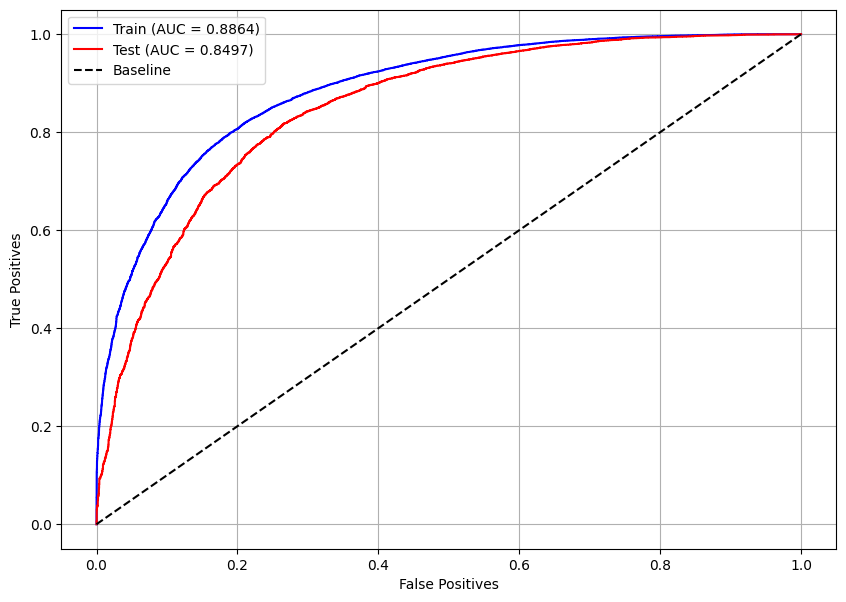

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

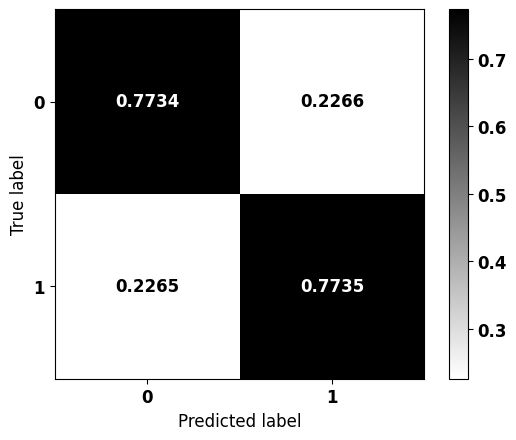


              precision    recall  f1-score   support

           0     0.4943    0.7734    0.6031      3270
           1     0.9226    0.7735    0.8415     11424

    accuracy                         0.7735     14694
   macro avg     0.7085    0.7735    0.7223     14694
weighted avg     0.8273    0.7735    0.7885     14694



In [15]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 104, 'max_depth': 10, 'min_samples_split': 6,
          'min_samples_leaf': 3, 'max_samples': 0.9, 'criterion': 'gini'}

params['random_state'] = seed
params['class_weight'] = {0:4.605, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

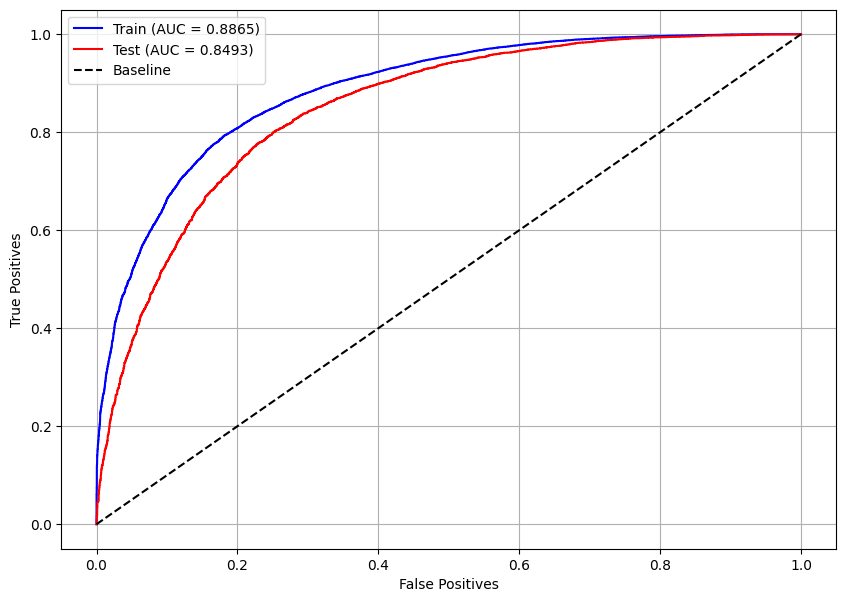

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

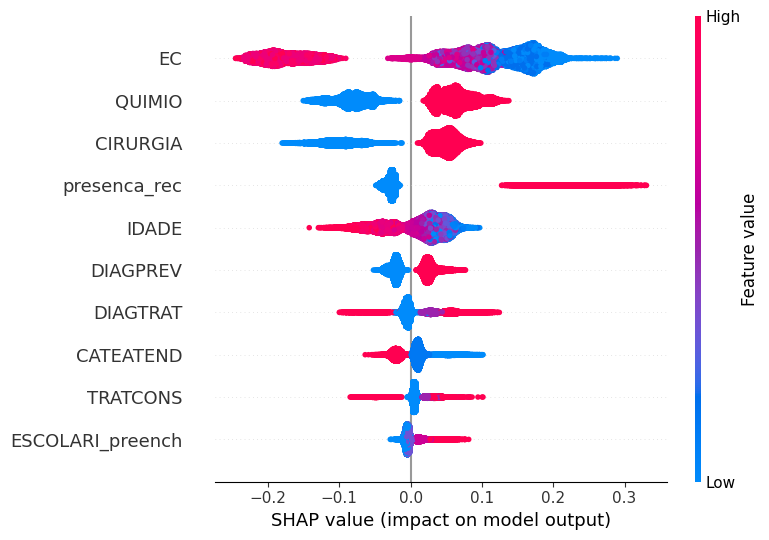

In [ ]:
# Importância das features pelos valores SHAP do modelo otimizado
plot_shap_values(rf_optuna, X_train, feat_cols)

## **XGBoost**


### **Modelo Base**

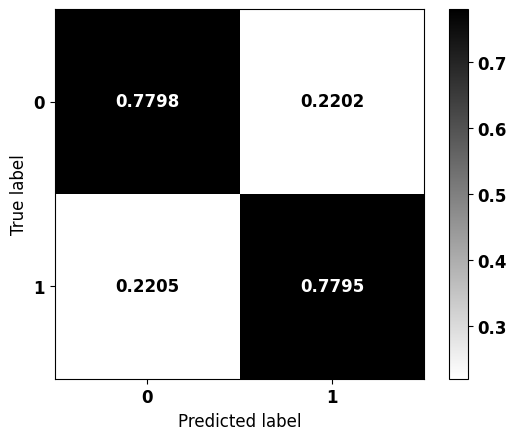


              precision    recall  f1-score   support

           0     0.5031    0.7798    0.6116      3270
           1     0.9252    0.7795    0.8461     11424

    accuracy                         0.7796     14694
   macro avg     0.7141    0.7797    0.7289     14694
weighted avg     0.8313    0.7796    0.7939     14694



In [16]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=0.241,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

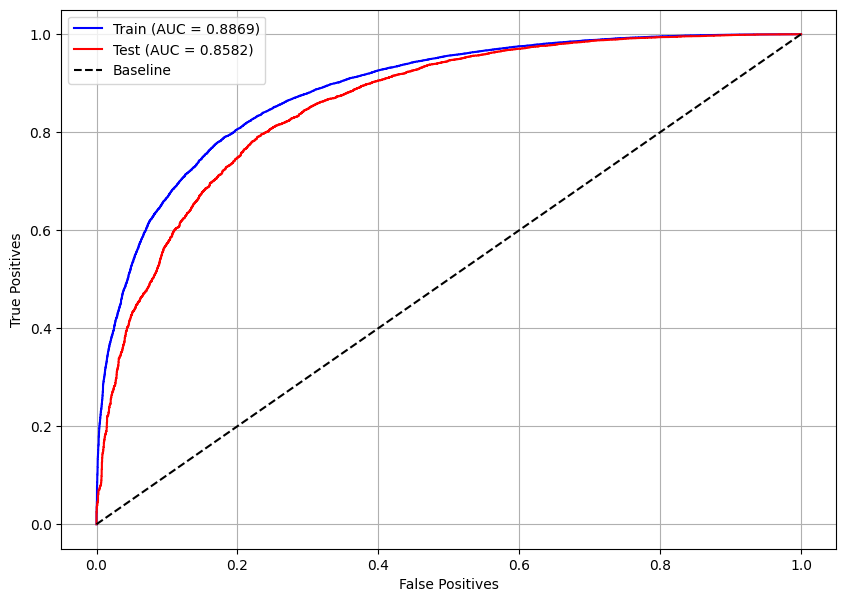

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

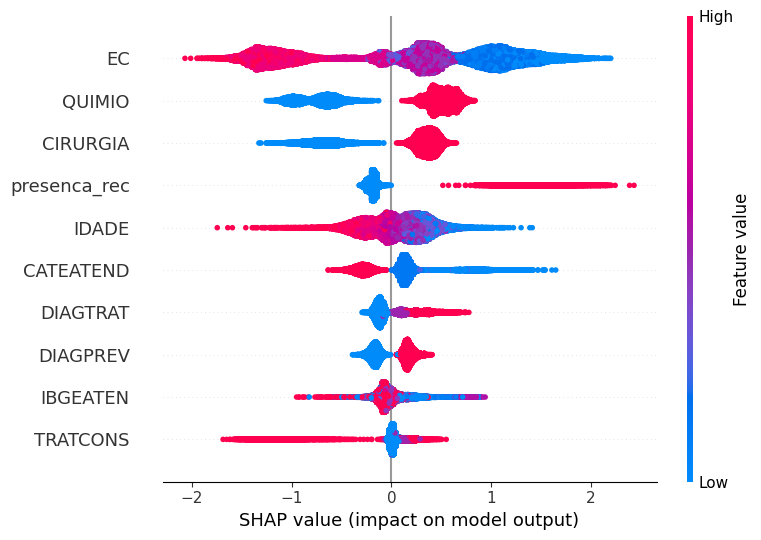

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=33, state=TrialState.COMPLETE, values=[0.8471032173507498], datetime_start=datetime.datetime(2023, 10, 10, 15, 31, 4, 625073), datetime_complete=datetime.datetime(2023, 10, 10, 15, 31, 13, 477626), params={'n_estimators': 82, 'max_depth': 6, 'learning_rate': 0.15000000000000002, 'gamma': 0.1, 'min_child_weight': 3, 'colsample_bytree': 0.6000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=33, value=None)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 82,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.23, 0.24, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

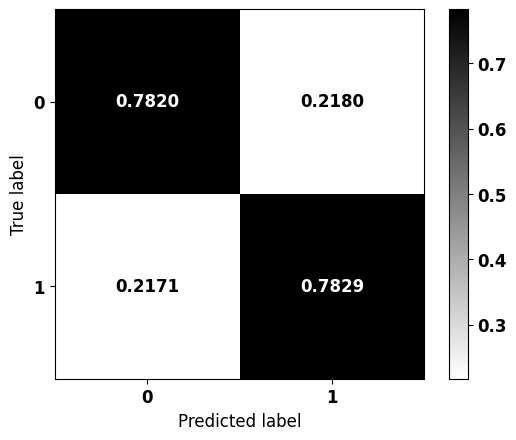


              precision    recall  f1-score   support

           0     0.5076    0.7820    0.6156      3270
           1     0.9262    0.7829    0.8485     11424

    accuracy                         0.7827     14694
   macro avg     0.7169    0.7824    0.7321     14694
weighted avg     0.8330    0.7827    0.7967     14694



In [21]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.2377

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

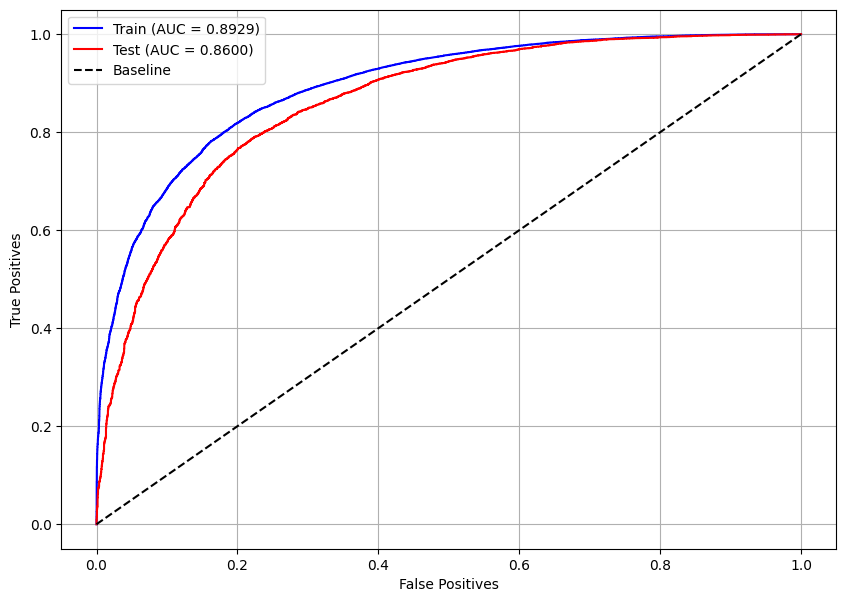

In [22]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 76,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.0,
 'min_child_weight': 3,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.23, 0.24, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

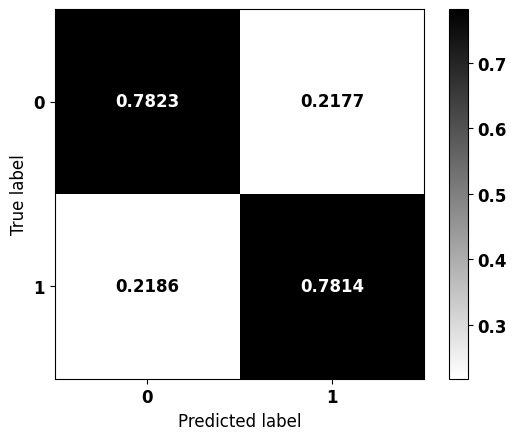


              precision    recall  f1-score   support

           0     0.5060    0.7823    0.6145      3270
           1     0.9261    0.7814    0.8476     11424

    accuracy                         0.7816     14694
   macro avg     0.7161    0.7818    0.7311     14694
weighted avg     0.8326    0.7816    0.7958     14694



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.2371

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

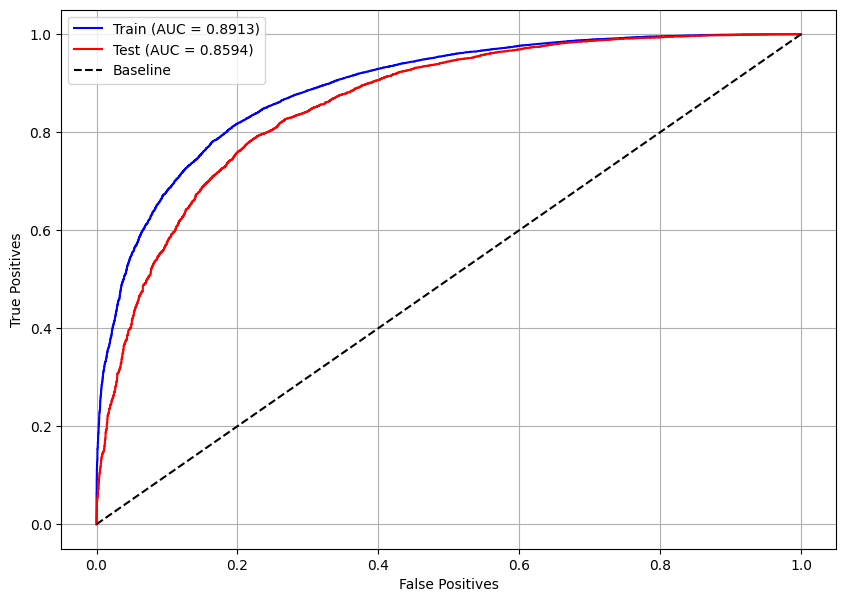

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 101,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 2,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.23, 0.24, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

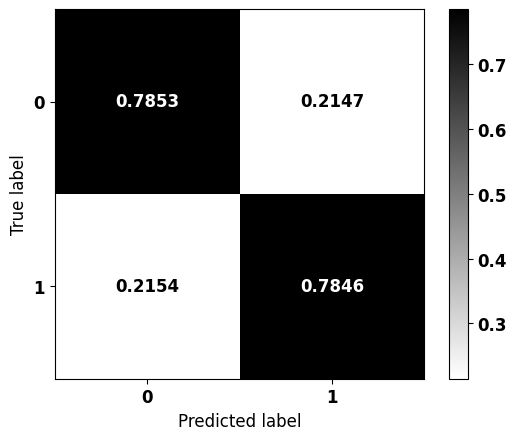


              precision    recall  f1-score   support

           0     0.5106    0.7853    0.6189      3270
           1     0.9274    0.7846    0.8500     11424

    accuracy                         0.7847     14694
   macro avg     0.7190    0.7849    0.7344     14694
weighted avg     0.8346    0.7847    0.7986     14694



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.235

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

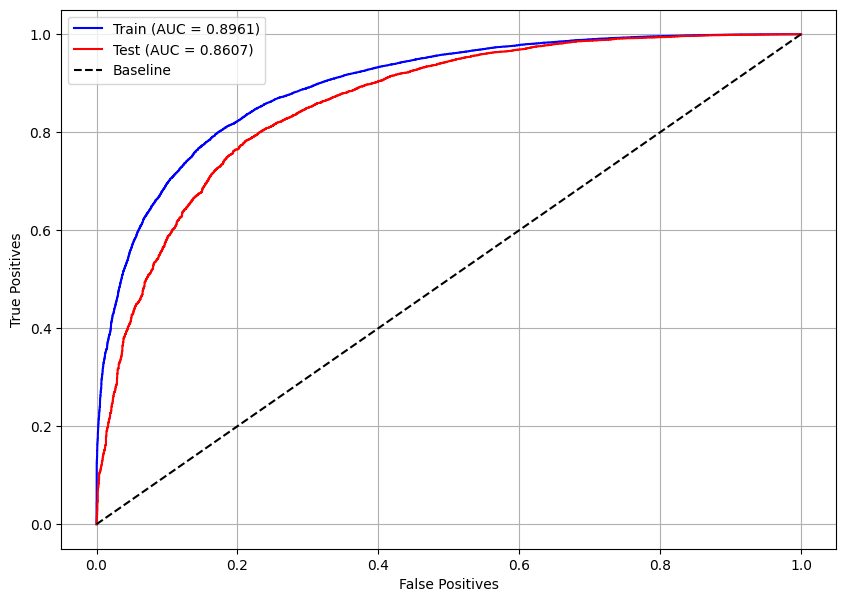

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

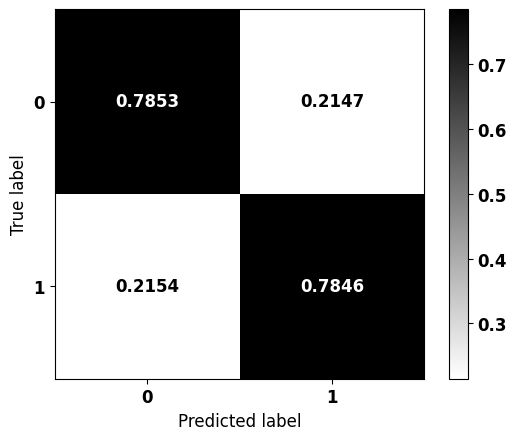


              precision    recall  f1-score   support

           0     0.5106    0.7853    0.6189      3270
           1     0.9274    0.7846    0.8500     11424

    accuracy                         0.7847     14694
   macro avg     0.7190    0.7849    0.7344     14694
weighted avg     0.8346    0.7847    0.7986     14694



In [28]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 101, 'max_depth': 6, 'learning_rate': 0.15,
          'gamma': 0.1, 'min_child_weight': 2, 'colsample_bytree': 0.5}

params['random_state'] = seed
params['scale_pos_weight'] = 0.235

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

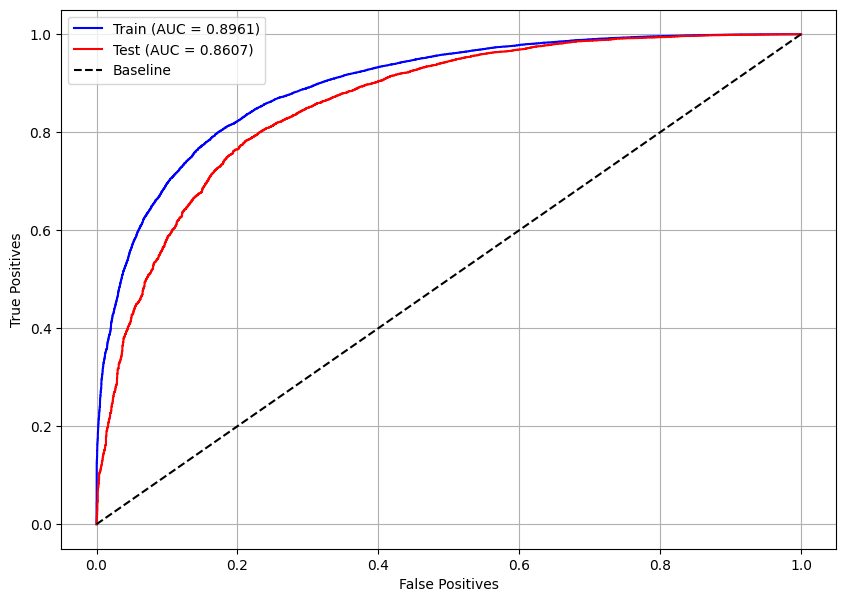

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

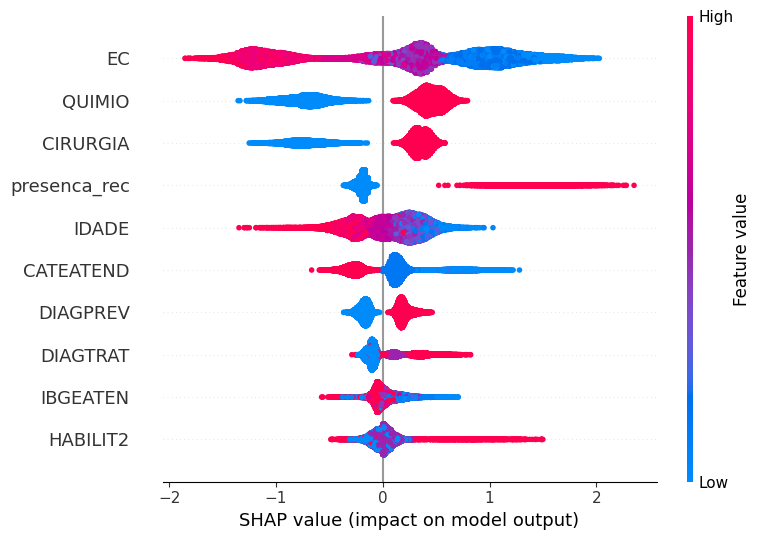

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

## **LightGBM**


### **Modelo Base**

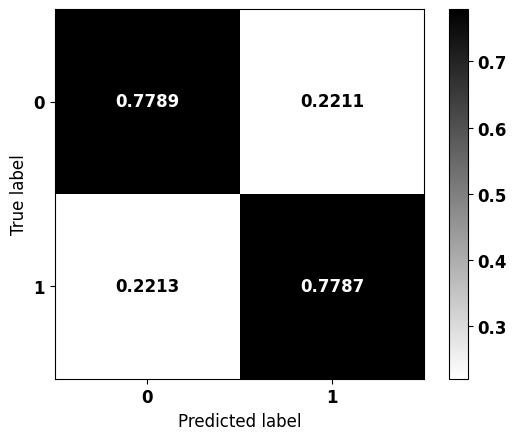


              precision    recall  f1-score   support

           0     0.5019    0.7789    0.6104      3270
           1     0.9248    0.7787    0.8455     11424

    accuracy                         0.7788     14694
   macro avg     0.7134    0.7788    0.7280     14694
weighted avg     0.8307    0.7788    0.7932     14694



In [29]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:4.2489, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

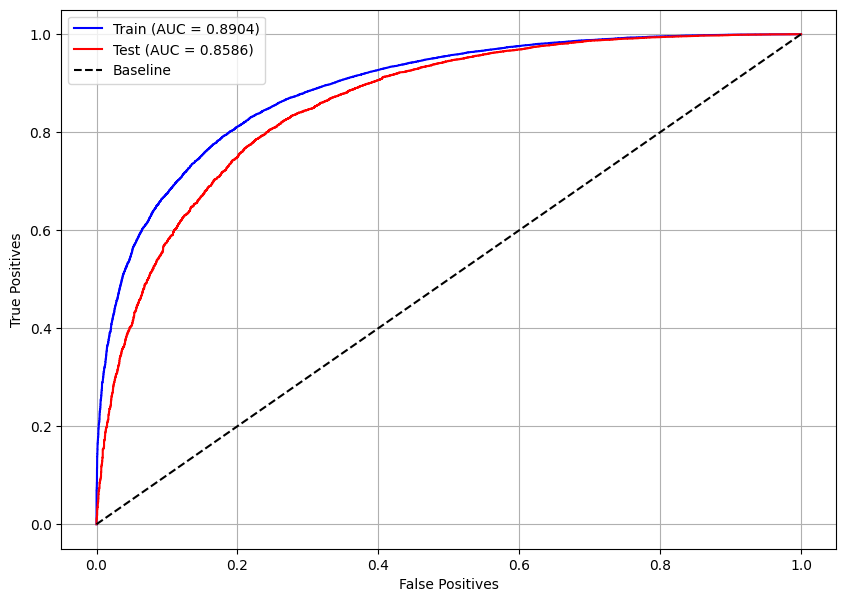

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

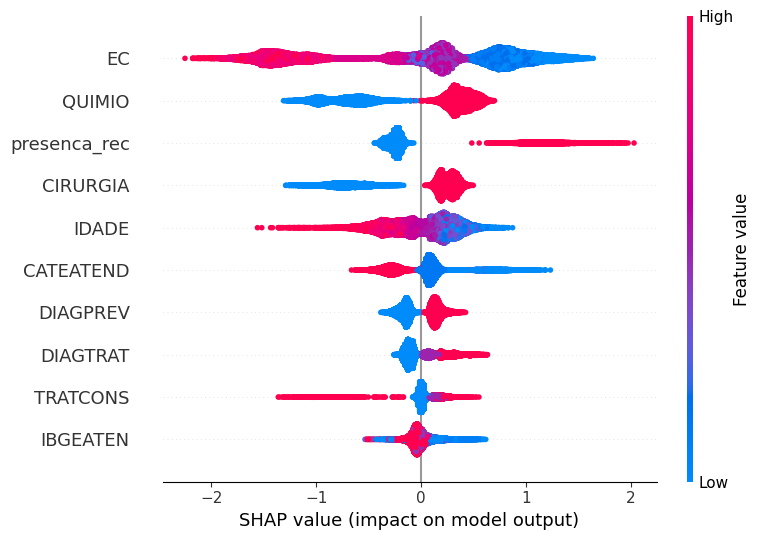

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyLGBM.best_trial

FrozenTrial(number=62, state=TrialState.COMPLETE, values=[0.8470124681037262], datetime_start=datetime.datetime(2023, 10, 10, 17, 11, 50, 414765), datetime_complete=datetime.datetime(2023, 10, 10, 17, 12, 12, 552266), params={'n_estimators': 141, 'max_depth': 10, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1, 'colsample_bytree': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=62, value=None)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 141,
 'max_depth': 10,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 1,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(4.285, 4.3, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

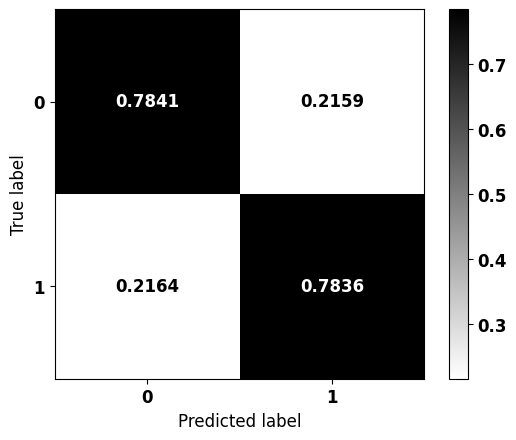


              precision    recall  f1-score   support

           0     0.5091    0.7841    0.6174      3270
           1     0.9269    0.7836    0.8493     11424

    accuracy                         0.7837     14694
   macro avg     0.7180    0.7839    0.7333     14694
weighted avg     0.8339    0.7837    0.7977     14694



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.29, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

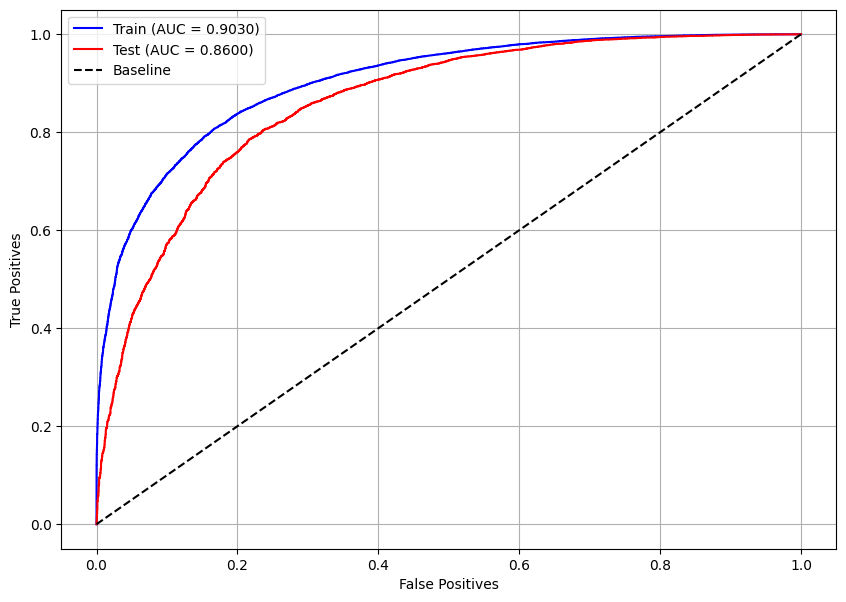

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 119,
 'max_depth': 7,
 'learning_rate': 0.14,
 'min_child_weight': 2,
 'colsample_bytree': 0.4}

In [34]:
pesos = np.round(np.arange(4.2, 4.23, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

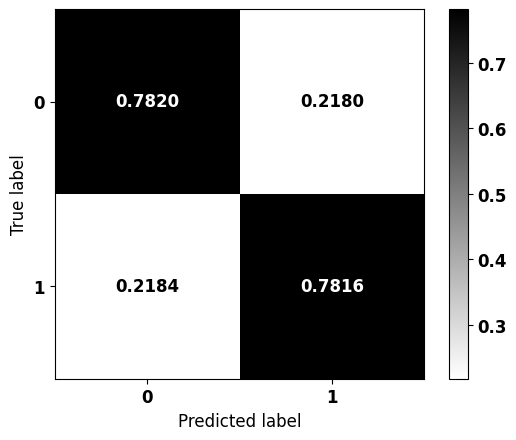


              precision    recall  f1-score   support

           0     0.5061    0.7820    0.6145      3270
           1     0.9261    0.7816    0.8477     11424

    accuracy                         0.7817     14694
   macro avg     0.7161    0.7818    0.7311     14694
weighted avg     0.8326    0.7817    0.7958     14694



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.21, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

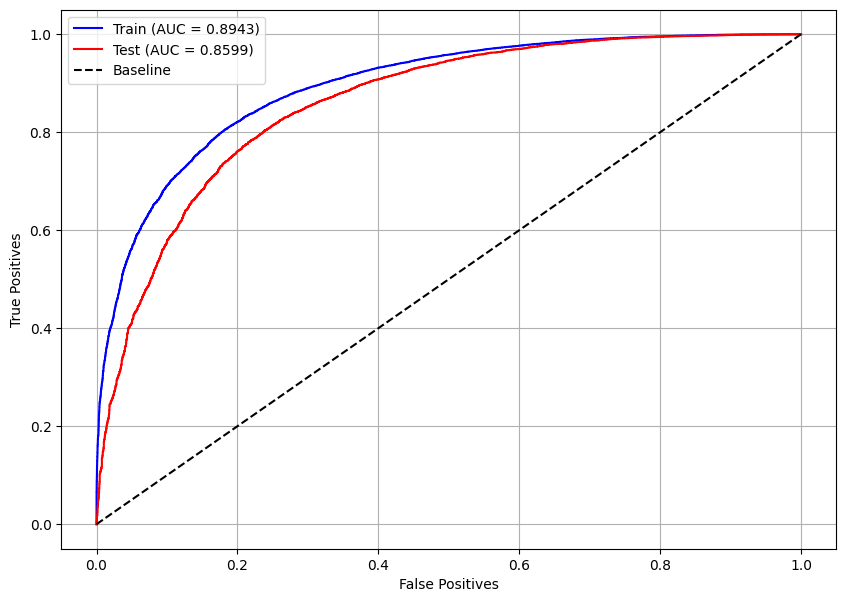

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 86,
 'max_depth': 7,
 'learning_rate': 0.14,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(4.14, 4.17, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

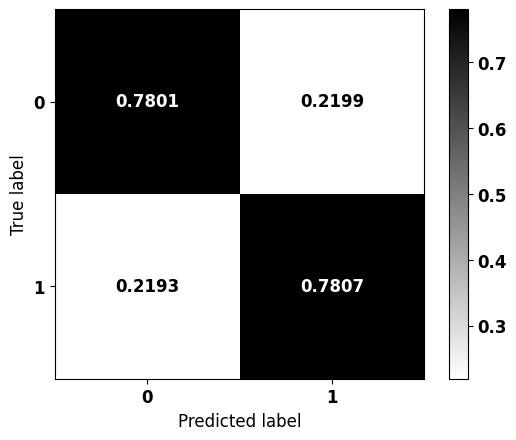


              precision    recall  f1-score   support

           0     0.5045    0.7801    0.6128      3270
           1     0.9254    0.7807    0.8469     11424

    accuracy                         0.7806     14694
   macro avg     0.7150    0.7804    0.7299     14694
weighted avg     0.8317    0.7806    0.7948     14694



In [37]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.151, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

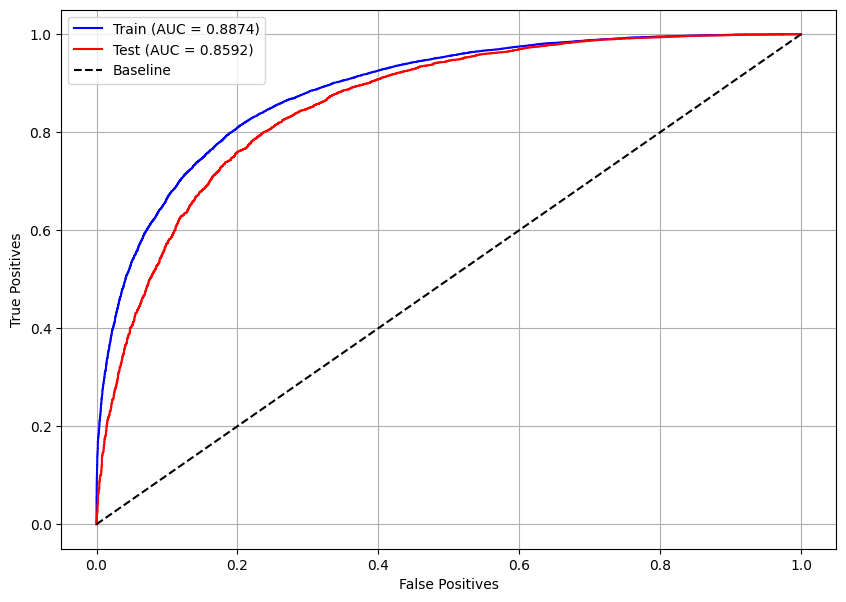

In [38]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

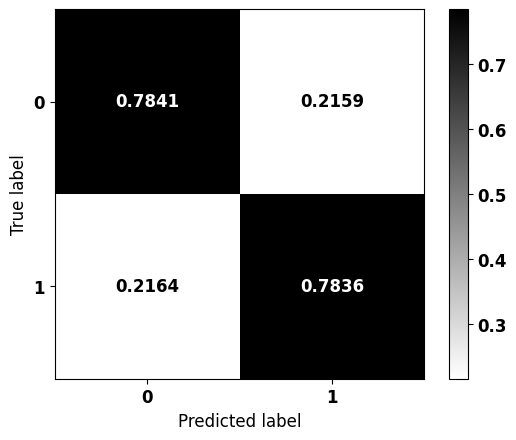


              precision    recall  f1-score   support

           0     0.5091    0.7841    0.6174      3270
           1     0.9269    0.7836    0.8493     11424

    accuracy                         0.7837     14694
   macro avg     0.7180    0.7839    0.7333     14694
weighted avg     0.8339    0.7837    0.7977     14694



In [39]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 141, 'max_depth': 10, 'learning_rate': 0.15,
          'min_child_weight': 1, 'colsample_bytree': 0.4}

params['random_state'] = seed
params['class_weight'] = {0:4.29, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

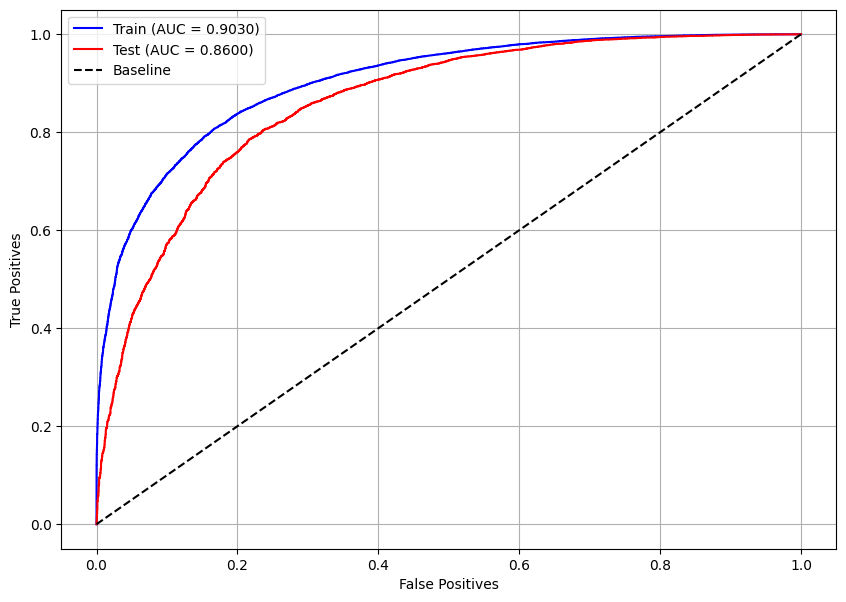

In [40]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

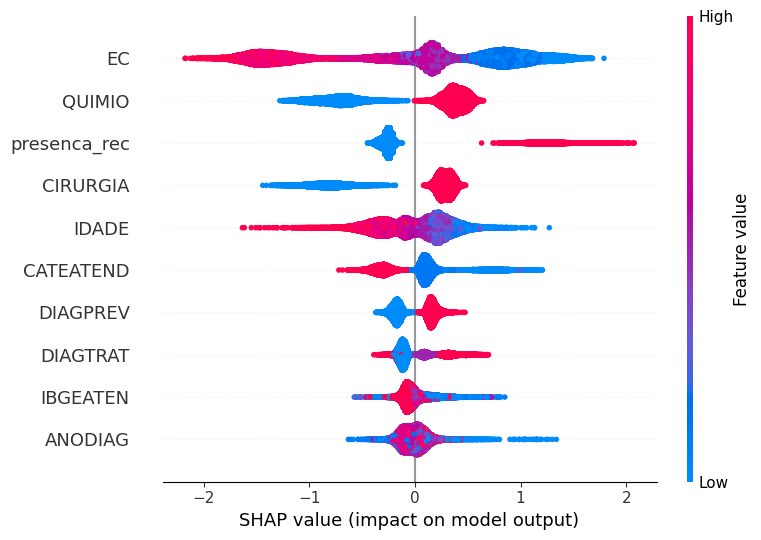

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [41]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7728, Optuna = 0.7735

Otimizado venceu


In [42]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7796, Optuna = 0.7847

Otimizado venceu


In [43]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7788, Optuna = 0.7837

Otimizado venceu


In [44]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 4.29, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.15, max_depth=10, min_child_weight=1,
               n_estimators=141, random_state=7, verbose=-1)

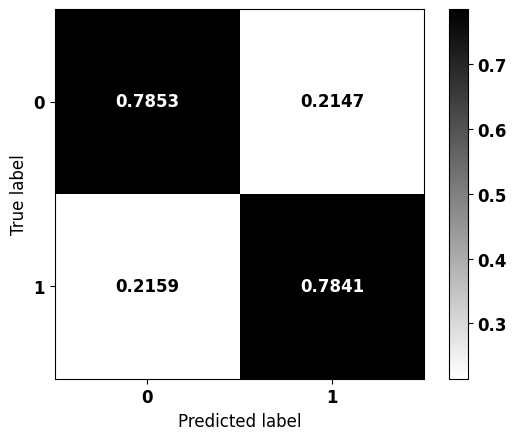


              precision    recall  f1-score   support

           0     0.5100    0.7853    0.6184      3270
           1     0.9273    0.7841    0.8497     11424

    accuracy                         0.7843     14694
   macro avg     0.7187    0.7847    0.7341     14694
weighted avg     0.8345    0.7843    0.7982     14694



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[#('RandomForest', best_rf),
                                   ('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

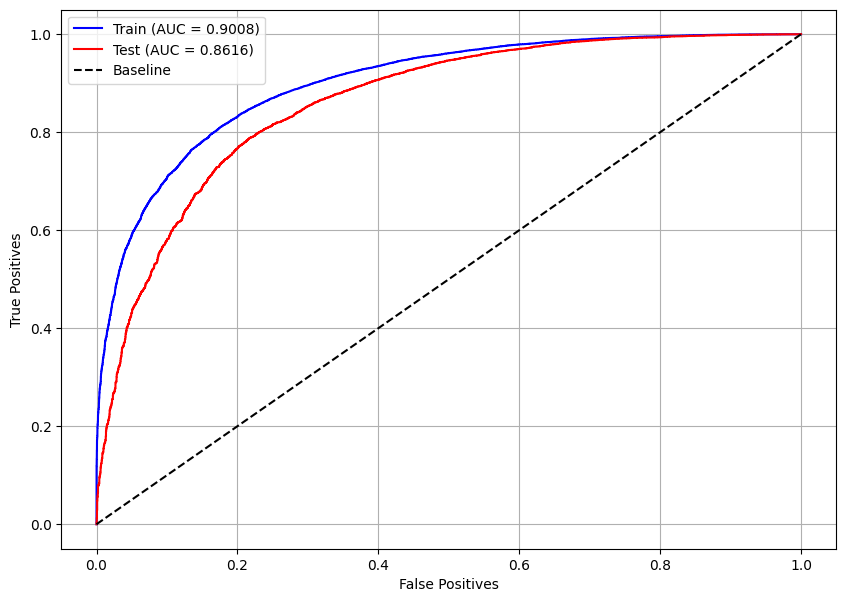

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [45]:
# Melhor modelo
models = [rf, rf_optuna, xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=101, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


In [ ]:
# Colunas que não serão utilizadas na predição cruzada
list_drop = list_drop + [lb]
list_drop

['TRATHOSP',
 'TOPO',
 'TOPOGRUP',
 'obito_geral',
 'sobrevida_ano3',
 'sobrevida_ano5',
 'sobrevida_ano1']

### **Pulmão**

In [ ]:
df_pulmao = pd.read_csv('/content/pulmao.csv')
print(df_pulmao.shape)
df_pulmao.head(3)

(38646, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


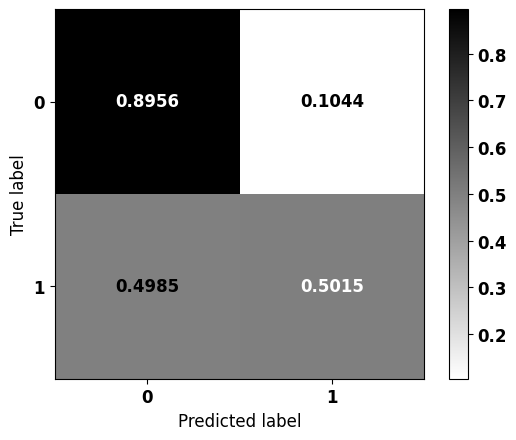


              precision    recall  f1-score   support

           0     0.7293    0.8956    0.8040     22687
           1     0.7620    0.5015    0.6049     15124

    accuracy                         0.7379     37811
   macro avg     0.7457    0.6985    0.7044     37811
weighted avg     0.7424    0.7379    0.7243     37811



In [ ]:
pred_cruzada(df_pulmao, best, list_drop, lb, enc, norm)

### **Mama**

In [ ]:
df_mama = pd.read_csv('/content/mama.csv')
print(df_mama.shape)
df_mama.head(3)

(117338, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,102,2,3550308,9,1,C509,C50,IIIB,D,0,...,6,3550308,2,3.0,1,1,1,1,0,0
1,28,2,3547809,9,2,C500,C50,I,G,0,...,1,3547809,1,4.0,1,0,1,1,1,1
2,27,2,3512001,2,2,C500,C50,I,H,0,...,13,3505500,2,4.0,0,1,0,1,1,1


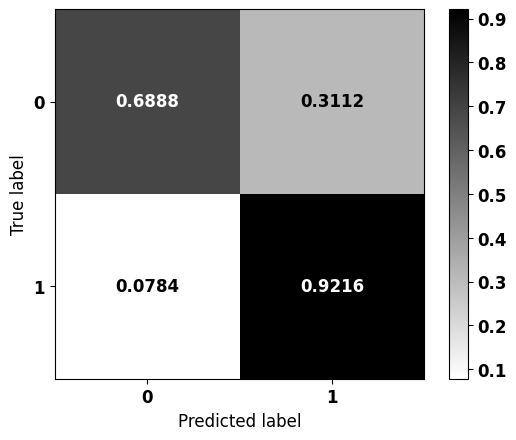


              precision    recall  f1-score   support

           0     0.3506    0.6888    0.4647      6546
           1     0.9797    0.9216    0.9498    106549

    accuracy                         0.9081    113095
   macro avg     0.6651    0.8052    0.7072    113095
weighted avg     0.9433    0.9081    0.9217    113095



In [ ]:
pred_cruzada(df_mama, best, list_drop, lb, enc, norm)

### **Colo de Útero**

In [ ]:
df_colo_utero = pd.read_csv('/content/colo_utero.csv')
print(df_colo_utero.shape)
df_colo_utero.head(3)

(23306, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,27,2,3548906,9,2,C530,C53,IIIB,B,0,...,13,3503208,1,4.0,0,0,1,1,0,0
1,29,2,3518701,9,1,C530,C53,IB2,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0
2,29,2,3522109,2,2,C530,C53,IB1,A,0,...,7,3550308,2,3.0,0,1,0,1,1,1


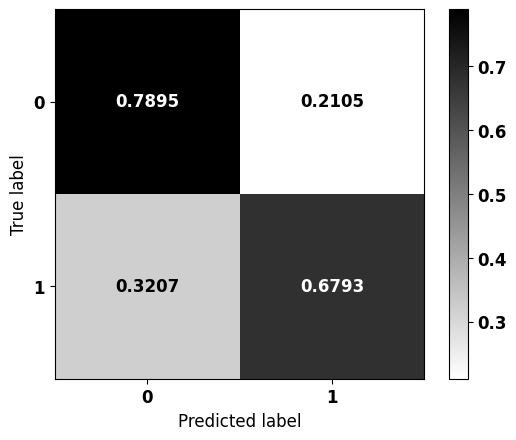


              precision    recall  f1-score   support

           0     0.3685    0.7895    0.5024      4300
           1     0.9316    0.6793    0.7857     18142

    accuracy                         0.7004     22442
   macro avg     0.6500    0.7344    0.6440     22442
weighted avg     0.8237    0.7004    0.7314     22442



In [ ]:
pred_cruzada(df_colo_utero, best, list_drop, lb, enc, norm)

### **Próstata**

In [ ]:
df_prostata = pd.read_csv('/content/prostata.csv')
print(df_prostata.shape)
df_prostata.head(3)

(94106, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


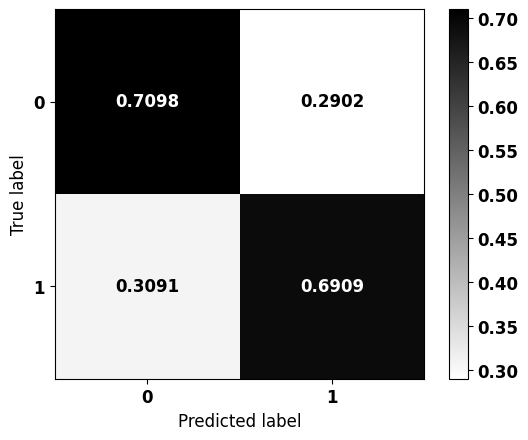


              precision    recall  f1-score   support

           0     0.1061    0.7098    0.1845      4421
           1     0.9788    0.6909    0.8100     85577

    accuracy                         0.6918     89998
   macro avg     0.5424    0.7004    0.4973     89998
weighted avg     0.9359    0.6918    0.7793     89998



In [ ]:
pred_cruzada(df_prostata, best, list_drop, lb, enc, norm)

### **Pele**

In [ ]:
df_pele = pd.read_csv('/content/pele.csv')
print(df_pele.shape)
df_pele.head(3)

(183164, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,101,2,3543402,9,1,C443,C44,I,I,0,...,13,3543402,2,2.0,1,0,1,1,0,0
1,100,1,3522802,2,1,C443,C44,II,A,0,...,9,3525300,2,1.0,0,0,1,1,0,0
2,105,2,3546603,9,1,C447,C44,I,A,0,...,12,3505500,2,1.0,0,0,1,0,0,0


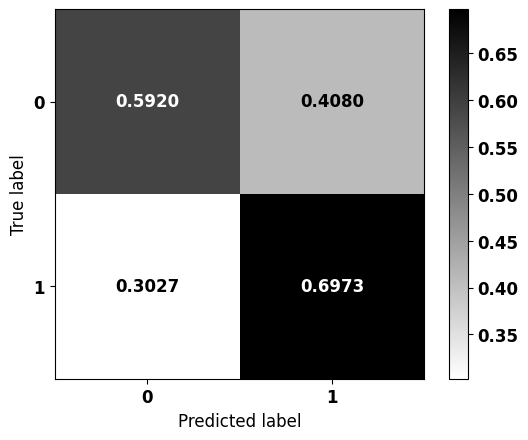


              precision    recall  f1-score   support

           0     0.1223    0.5920    0.2027      8108
           1     0.9600    0.6973    0.8078    113813

    accuracy                         0.6903    121921
   macro avg     0.5411    0.6447    0.5053    121921
weighted avg     0.9043    0.6903    0.7676    121921



In [ ]:
pred_cruzada(df_pele, best, list_drop, lb, enc, norm)